# Attention Model for DPP


For Haeyeon

Brief intro: implementation-wise, the biggest differences with most RL libraries are:
1. We use [TorchRL](https://github.com/pytorch/rl) for batched environments on GPU - tackling one of the biggest bottlenecks in RL (CPU-GPU overheads)
2. We pass states and more in the super-convenient [TensorDicts](https://github.com/pytorch-labs/tensordict)
3. Training is done in [PyTorch Lightning](https://github.com/Lightning-AI/lightning), which takes care of multiple devices, logging, checkpointing, etc.
4. We use [Hydra](https://hydra.cc/) for configuration management
5. Code is made to be as modular as possible and implemented with the latest DL advances as [FlashAttention](https://github.com/HazyResearch/flash-attention)


This should allow for easy, fast, and scalable experimentation in the future and we hope to become the to-go library for RL4CO research 🚀

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import DictConfig

import torch
from torch.utils.data import DataLoader
import lightning as L

from rl4co.envs import DPPEnv
from rl4co.data.dataset import tensordict_collate_fn, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

/home/haeyeon/rl4co/env/lib/python3.8/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/haeyeon/rl4co/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DPP Environment

We declare the environment here. This will automatically download the data 

In [2]:
env = DPPEnv()

td = env.reset(batch_size=[2])
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        first_node: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([2, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=False)


/home/haeyeon/rl4co/env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
bs = 10

td = env.reset(batch_size=[bs])

actions = []
probes = td['probe'].clone()
keepouts = td['action_mask'].clone() # this includes also the probes + decaps placed later

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td

for i in range(20):
    # pick random action from action_mask
    td = random_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions = torch.stack(actions, dim=1)

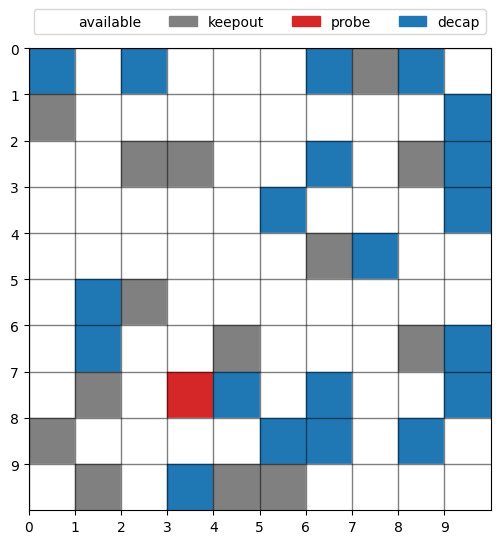

In [4]:
# Plot 
idx = 0

decaps = actions[idx]
probe = probes[idx]
action_mask = keepouts[idx]

env.render(decaps=decaps, probe=probe, action_mask=action_mask)

## Test the Policy only

In [5]:
# Load environment with test data
env = DPPEnv(val_file="test.npz", test_file="test.npz")

env.max_decaps = 20

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=tensordict_collate_fn,
)

policy = AttentionModelPolicy(
    env,
)

# model = torch.compile(model)

td = next(iter(dataloader))
td = env.reset(td)

out = policy(td, decode_type="sampling")

print(out)

{'reward': tensor([10.2599, 10.0027,  8.9136,  8.5639, 11.4526,  9.5998,  8.7554, 11.3288,
         7.4011,  8.3115, 10.1335, 11.0200,  8.7741,  8.6011, 10.7150, 11.4227,
         9.2410,  9.7686,  9.3768,  9.1879,  7.2578,  8.0650, 12.8476, 12.1162,
         8.9530, 10.2642, 10.3033, 10.2102,  9.7741, 11.3733,  9.7401,  7.2201,
         8.4346,  9.1263, 12.7028, 10.4791, 11.6081, 12.3069,  8.8388, 10.3036,
         8.8503,  8.2874, 11.4268,  9.3423,  7.8123, 10.3180,  8.7662, 12.4474,
         9.3942, 10.1234, 10.6965, 11.2536,  6.2776, 10.6145, 10.3915, 13.9056,
         8.0316, 10.7852,  7.6440,  9.7571, 10.1046, 11.3577,  9.2464, 10.5867],
       dtype=torch.float64), 'log_likelihood': tensor([-81.5489, -73.5362, -80.8322, -83.9544, -83.3711, -82.9377, -85.9551,
        -58.3134, -79.0674, -80.0868, -77.5908, -66.3891, -68.9594, -82.1640,
        -87.2872, -75.7752, -84.5926, -81.4385, -77.9332, -81.1289, -76.3247,
        -83.4255, -83.3664, -65.8761, -81.8725, -74.9794, -84.7746,

## Create full AM: `env` + `policy` + `baseline`

In [6]:
model = AttentionModel(
    env,
    policy,
)


td = next(iter(dataloader))
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([11.4593, 11.0536,  7.9348, 10.5085,  9.9230,  9.4221,  9.9196, 11.6770,
        14.6605,  9.1148, 10.0871, 10.9977,  9.3504, 11.0811, 11.6156, 15.5031,
        10.1628,  8.9531,  9.5232,  9.9340, 11.1150,  9.2764, 11.4280, 11.0474,
        10.1989, 10.3745,  9.4194,  8.6955, 10.7287, 15.7267, 12.5293,  7.1991,
         7.3396, 10.6967, 12.8662,  8.0404, 10.2244, 11.1941, 10.6601,  8.9664,
        11.3047,  9.2796, 11.0523,  8.3423, 10.2811, 10.3696,  8.3755, 10.1075,
        10.2344, 10.0711,  9.0929,  8.9899, 12.2452, 10.9631,  9.3689, 10.0562,
        10.5034, 10.5451,  9.0708,  9.1980,  9.7248, 11.2744, 10.8320,  8.1695],
       dtype=torch.float64), 'log_likelihood': tensor([-79.1984, -77.1437, -82.9294, -85.2290, -83.6451, -76.2423, -80.2734,
        -61.2026, -72.1186, -80.8967, -78.7616, -70.8692, -74.9057, -76.9960,
        -83.8335, -74.6263, -81.8346, -79.0391, -80.5508, -82.3683, -70.3755,
        -84.3652, -84.3172, -72.7917, -79.5963, -77.5420, -86.9939,

## Main training setup

In [7]:
config = DictConfig(
    {"data": {
            "train_size": 1000, # with 1 epochs, this is 1k samples
            "val_size": 100, 
            "batch_size": 64,
    },
    "optimizer": {
        "lr": 1e-4,
        "weight_decay": 1e-3,
    }})

# Recreate model (so CUDA is initialized in the model)

model = AttentionModel(env)

lit_module = RL4COLitModule(cfg=config, env=env, model=model)

## Fit model

In [8]:
# Trainer
trainer = L.Trainer(
    max_epochs=2, # only few epochs
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    devices=[0], # GPU number, or multiple GPUs [0, 1, 2, ...]
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle faster training with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haeyeon/rl4co/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/haeyeon/rl4co/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/haeyeon/rl4co/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haeyeon/rl4co/env/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it, v_num=3, train/reward=12.20, train/loss=96.90, val/reward=12.90]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it, v_num=3, train/reward=12.20, train/loss=96.90, val/reward=12.90]


In [9]:
trainer.test(lit_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
No test_size specified, using default as 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/haeyeon/rl4co/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    12.907608008601764     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': 12.907608008601764}]

## Analyze results

In [19]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy")
out['reward'].mean()

tensor(11.6704, device='cuda:0', dtype=torch.float64)

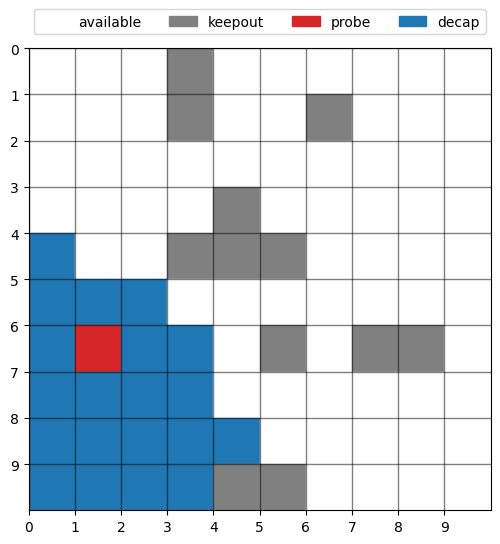

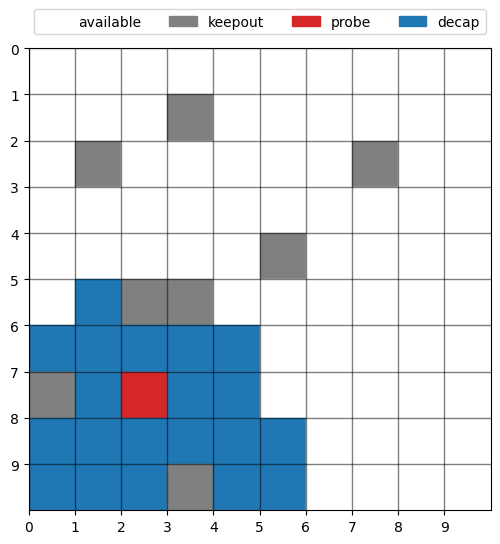

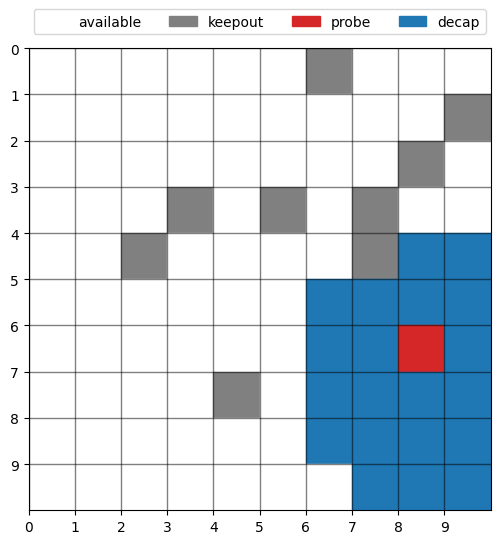

In [20]:
## Plot
import matplotlib.pyplot as plt

init_td = env.reset(batch).to("cuda")
probes = init_td['probe'].clone().cpu()
keepouts = init_td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(3):
    env.render(decaps[i], probes[i], keepouts[i])


## Effect of heuristics policy

In [88]:
td = init_td.clone().cpu()

def heuristics_policy(td):
    # select the available location closest to the probe
    action_mask = td['action_mask']
    probe = td['probe']
    probe_loc = td['locs'].gather(1, probe.unsqueeze(-1).expand(-1, -1, 2))
    available_locs = torch.where(action_mask.unsqueeze(-1).expand(-1, -1, 2), td['locs'], torch.tensor(float('inf')))
    dist = torch.norm(probe_loc - available_locs, dim=-1)
    action = dist.argmin(dim=-1).squeeze(-1)
    td.set("action", action)
    return td

actions = []

for i in range(20):
    # pick random action from action_mask
    td = heuristics_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions = torch.stack(actions, dim=1)
rewards = env.get_reward(td, actions)
print(rewards.mean())

tensor(12.9349, dtype=torch.float64)


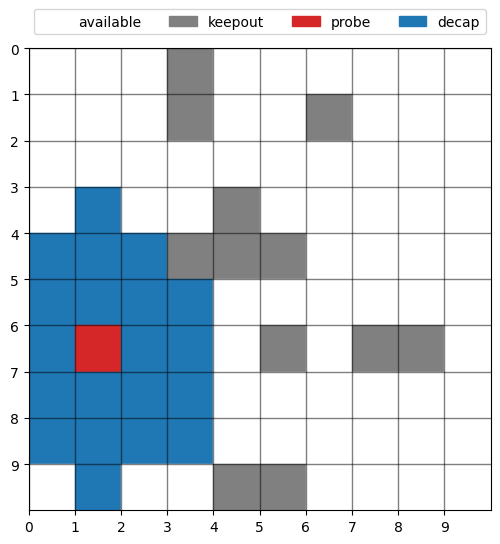

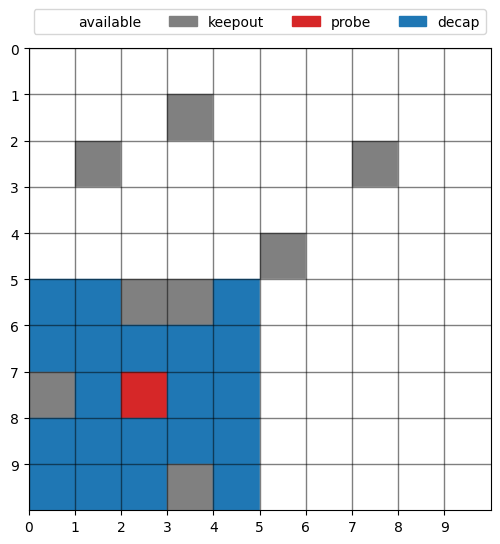

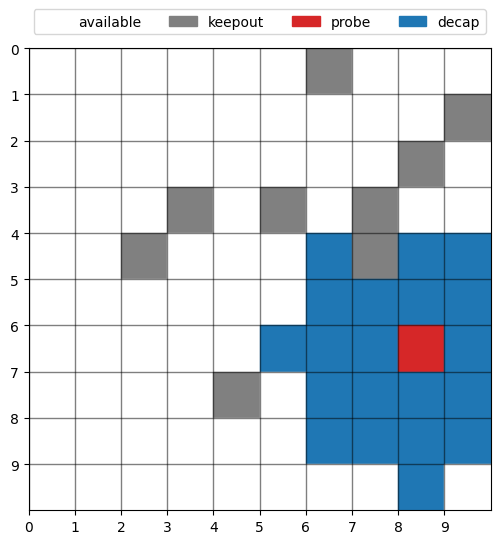

In [89]:
decaps = actions.cpu()

for i in range(3):
    env.render(decaps[i], probes[i], keepouts[i])

## Num decaps vs. reward

In [ ]:
from tqdm.auto import tqdm

# Test the model with different number of actions
reward_list = []


for num_decaps in tqdm(range(1, 30)):

    batch = next(iter(dl))
    td = env.reset(batch).to("cuda")
    policy.decoder.env.max_decaps = num_decaps
    out = policy(td, decode_type="greedy")
    reward_list.append(out['reward'].mean().item())

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Text(0, 0.5, 'Score')

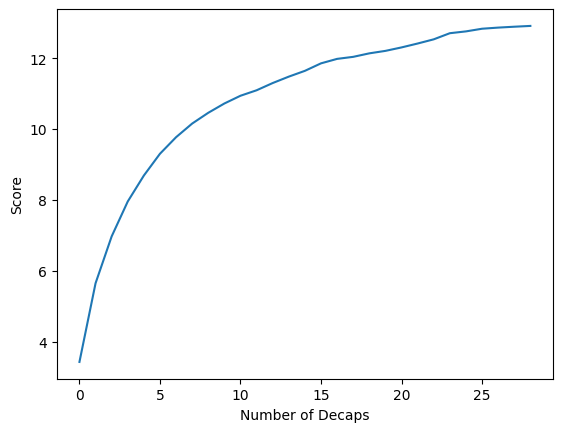

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(reward_list)
plt.xlabel("Number of Decaps")
plt.ylabel("Score")